# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 10

## Rui Fang $\quad$ Collaborator: /

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 13th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem #1: Iris Eyes Are Smiling

This Homework problem is a continuation of Problem #4 from Homework 8.  We'll be using the same iris dataset. The iris data can be obtained [here](./iris.csv).

Now that we have from Homework 8 Problem #4 a train-test split as well as point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

** *Note this next section is just guidance and doesn't contain any work for you to do* **

*There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

*There are multiple ways in which you can do these probability estimates at a sample $x$:*

(A) You can just use a point estimate like the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

** *Note this next section contains the tasks we expect you to complete* **


1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?


***

### *Solution*

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import seaborn as sns
sns.set()

/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load in data
iris_df = pd.read_csv('iris.csv')
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
from sklearn.model_selection import train_test_split

# Preprocess data
N = iris_df.shape[0]

X = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
X = np.concatenate([np.ones((N, 1)), X], axis=1)

y = np.zeros(N)
y[iris_df['class'].values == ' Iris-virginica'] = 1

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

In [4]:
import theano.tensor as T

# Construct the logistic model 
with pm.Model() as model:

    beta = pm.Normal('beta', mu=0, sd=10, shape=5) 
    p = pm.Deterministic('p', 1/(1 + T.exp(-T.dot(X_train, beta))))
    yhat = pm.Bernoulli('yhat', p, observed=y_train)
    
    trace = pm.sample(10000, pm.NUTS())

    pp_samples = pm.sample_ppc(trace, model=model)

/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
100%|██████████| 10500/10500 [03:44<00:00, 46.86it/s]
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
There were 448 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 10000/10000 [00:04<00:00, 2255.62it/s]


<IPython.core.display.Javascript object>


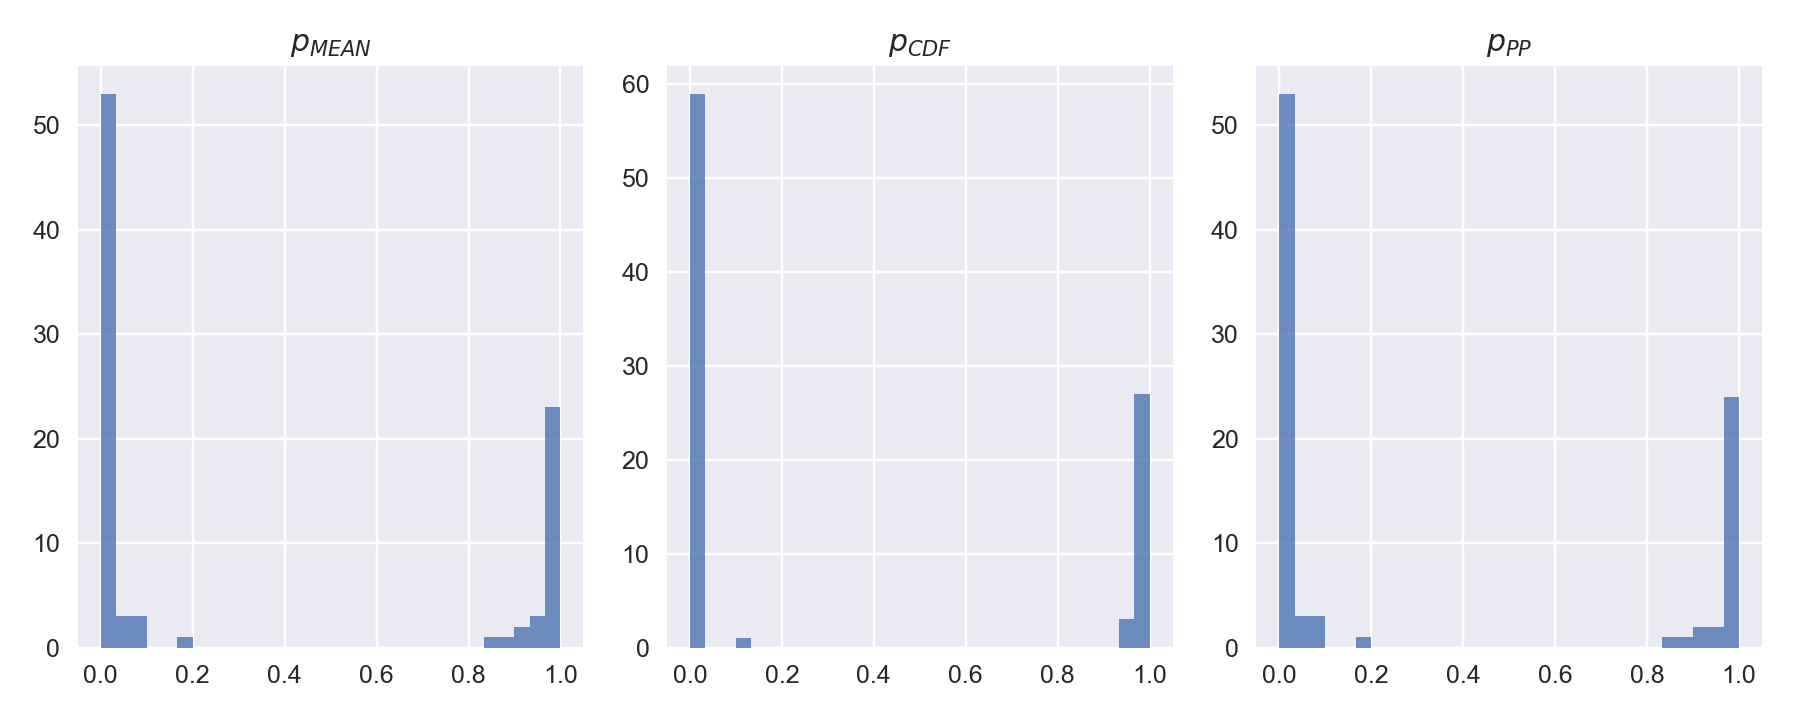

In [5]:
# Get probability estimates 
p_mean = np.mean(trace['p'], axis=0)     
p_cdf = np.sum(trace['p'] > 0.5, axis=0)/trace['p'].shape[0]
p_pp = np.sum(pp_samples['yhat'], axis=0)/pp_samples['yhat'].shape[0]

# Plot distributions over all data points in the training set 
plt.figure(figsize=(10,4))

plt.subplot(131)
plt.hist(p_mean, 30, alpha=0.8)
plt.title(r'$p_{MEAN}$')
plt.subplot(132)
plt.hist(p_cdf, 30, alpha=0.8)
plt.title(r'$p_{CDF}$')
plt.subplot(133)
plt.hist(p_pp, 30, alpha=0.8)
plt.title(r'$p_{PP}$')

plt.tight_layout()
plt.show()

The three distributions are overall very similar, with most values being 0 and 1. Compared with $p_{CDF}$, $p_{MEAN}$ and $p_{PP}$ got slightly wider distributions around 0 and 1.

<IPython.core.display.Javascript object>


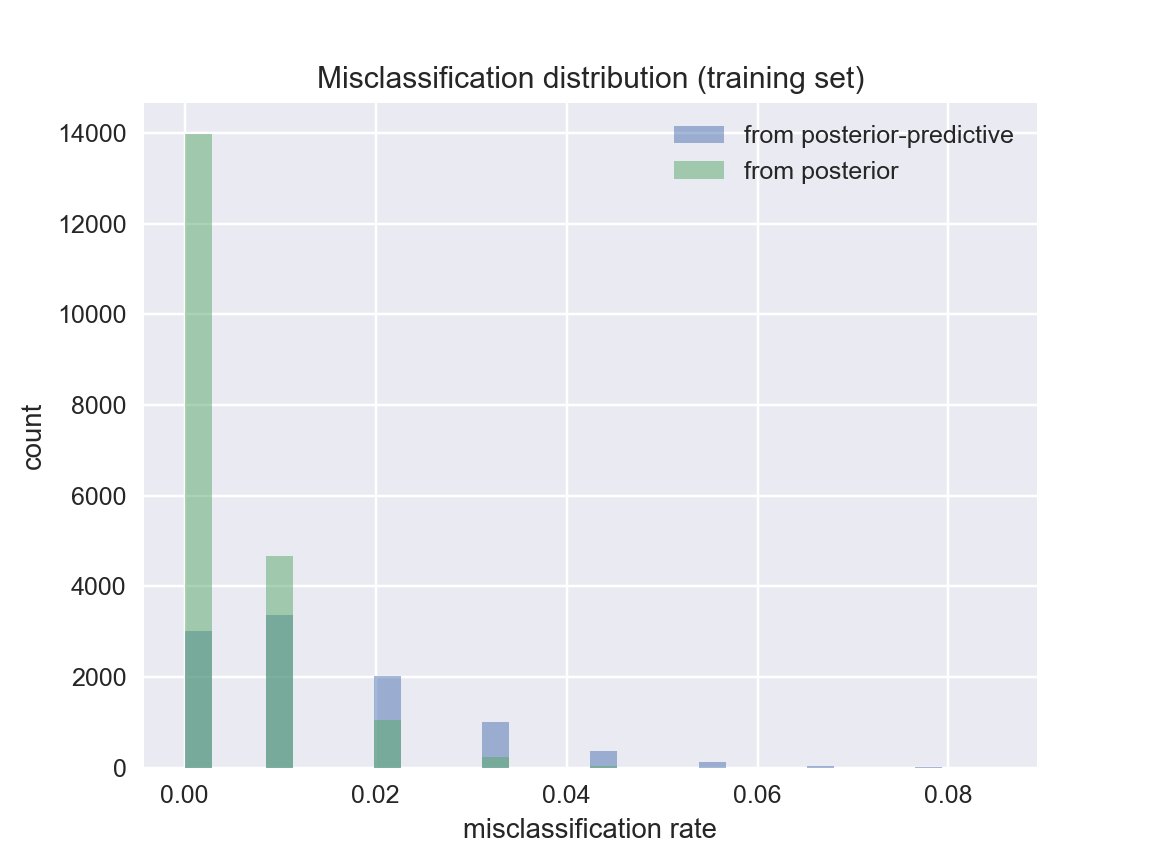

In [6]:
# Compute misclassification rate on the training set from posterior-predictive and from posterior 
mis_rate_pos_train = 1-np.sum((trace['p'] > 0.5)==y_train, axis=1)/trace['p'].shape[1]
mis_rate_pp_train = 1-np.sum(pp_samples['yhat']==y_train, axis=1)/pp_samples['yhat'].shape[1]

# Plot distributions
plt.figure()
plt.hist(mis_rate_pp_train, 30, range=(0, 0.085), alpha=0.5, label='from posterior-predictive')
plt.hist(mis_rate_pos_train, 30, range=(0, 0.085), alpha=0.5, label='from posterior')
plt.xlabel('misclassification rate')
plt.ylabel('count')
plt.title('Misclassification distribution (training set)')
plt.legend()
plt.show()

According to the histograms, the distribution of the misclassification rate from the posterior-predictive is wider than that from the posterior using MLDT.

In [7]:
# Compute occurences of true classification labels in posterior predictive trace 
pp_samples_text = np.array([np.array2string(sample, max_line_width=200, separator='')[1:-1] 
                            for sample in pp_samples['yhat']])
y_train_text = np.array2string(y_train.astype(int), max_line_width=200, precision=0, separator='')[1:-1]

unique, counts = np.unique(pp_samples_text, return_counts=True)
order = counts.argsort()[::-1]
sorted_unique = unique[order]
sorted_counts = counts[order]

print('Occurences of unique predicted bitstrings in decreasing order:', sorted_counts)

if y_train_text in sorted_unique:
    print('Occurences of true bitstring:', sorted_counts[np.argwhere(sorted_unique==y_train_text)][0])

Occurences of unique predicted bitstrings in decreasing order: [3025  701  425 ...    1    1    1]
Occurences of true bitstring: [3025]


Yes, the classification at the true training data points (the true bitstring '100101...' of 90 characters long) is represented in the posterior predictive trace. It is the most frequent string in the traces with 3025 occurences. Thus the posterior predictive provides relatively accurate predictions. However, using MLDT from the posterior is even better according to the misclassification rate distributions. 

<IPython.core.display.Javascript object>


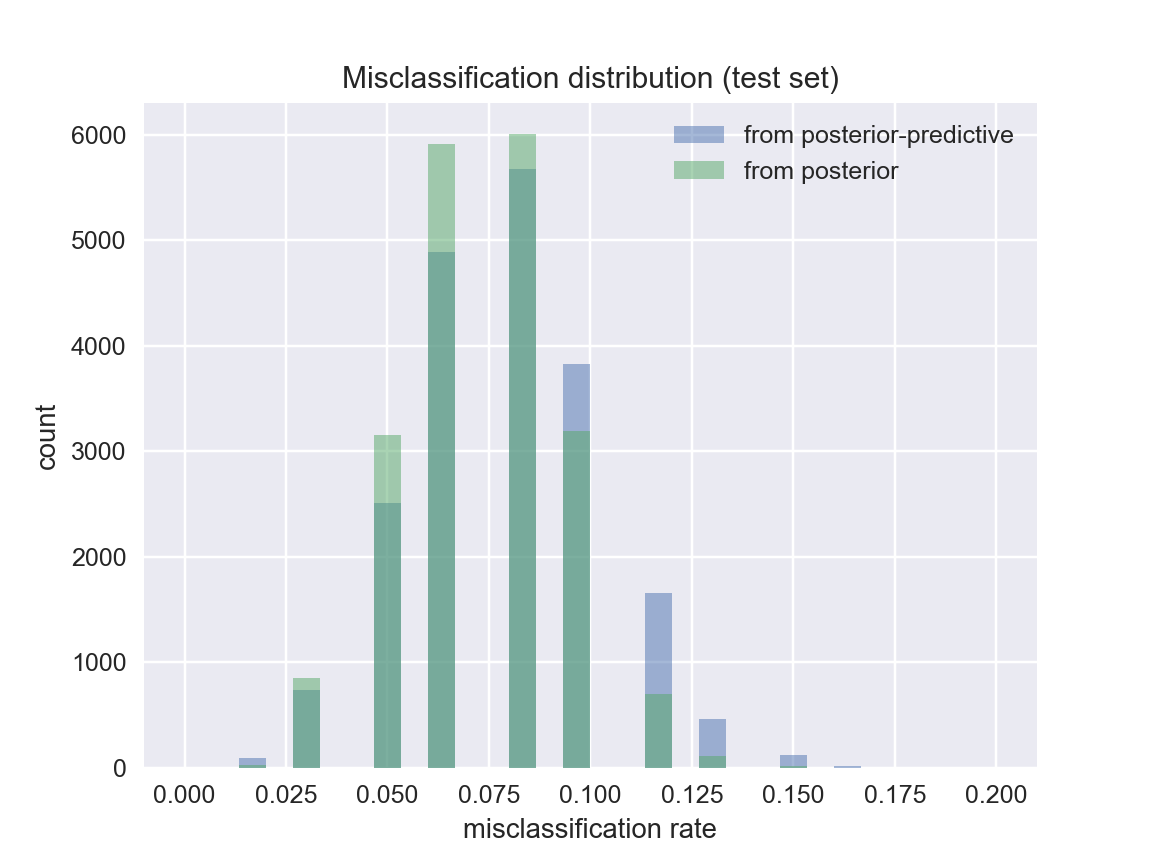

In [8]:
# Generate posterior and posterior predictives for the test set
p_pos_test = 1/(1 + np.exp(-np.dot(trace['beta'], X_test.T)))
yhat_test = np.random.binomial(n=1, p=p_pos_test)

# Compute misclassification rate on the test set from posterior-predictive and from posterior 
mis_rate_pos_test = 1-np.sum((p_pos_test > 0.5)==y_test, axis=1)/p_pos_test.shape[1]
mis_rate_pp_test = 1-np.sum(yhat_test==y_test, axis=1)/yhat_test.shape[1]

# Plot distributions
plt.figure()
plt.hist(mis_rate_pp_test, 30, range=(0, 0.20), alpha=0.5, label='from posterior-predictive')
plt.hist(mis_rate_pos_test, 30, range=(0, 0.20), alpha=0.5, label='from posterior')
plt.xlabel('misclassification rate')
plt.ylabel('count')
plt.title('Misclassification distribution (test set)')
plt.legend()
plt.show()

For the test set, both distributions shift right (the mean misclassification rate becomes larger) compared to the distributions for the training set. We again observed that the width of the distribution from the posterior-predictive is greater than that from the posterior using MLDT, meaning using MLDT to make predictions tends to be more accurate than using the posterior-predictive. 

***

## Problem 2: From the Ritz to the Rubble

In this problem, much like in Long Homework 9, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 
- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

***

### *Solution*

In [9]:
# Load in data
census_df = pd.read_csv('census_data.csv')
census_df.head()

,Unnamed: 0,age,sector,edu,marital,race,sex,earning
0,0,39,State-gov,Bachelors,Never-married,White,Male,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K
2,2,38,Private,HS-grad,Divorced,White,Male,<=50K
3,3,53,Private,11th,Married-civ-spouse,Black,Male,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K


In [10]:
# Obtain unique entries in 'edu' column 
census_df['edu'].unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

In [11]:
# Convert to seven categories  
convert_edu = {'Bachelors':'4 year college degree', 
               'HS-grad':'High school', 
               '11th':'Some or no high school', 
               'Masters':'Masters', 
               '9th':'Some or no high school', 
               'Some-college':'Some-college or two year academic college degree',
               'Assoc-acdm':'Professional, vocational school', 
               'Assoc-voc':'Professional, vocational school', 
               '7th-8th':'Some or no high school', 
               'Doctorate':'Doctorate', 
               'Prof-school':'Professional, vocational school',
               '5th-6th':'Some or no high school', 
               '10th':'Some or no high school', 
               '1st-4th':'Some or no high school', 
               'Preschool':'Some or no high school', 
               '12th':'Some or no high school'}
census_df['education'] = census_df['edu'].map(convert_edu)

# Assign 0 to earning<=50K and 1 to earning>50K
census_df['>50K'] = census_df['earning'].map({'<=50K':0, '>50K':1})

# Aggregate data set by counting total numbers of males and females and those who make above 50K in each category 
df = census_df.groupby(['education', 'sex'])['>50K'].agg(['sum', 'count']).reset_index()
df = df.rename(columns={'sum': '>50K', 'count': 'total'})
df

,education,sex,>50K,total
0,4 year college degree,Female,339,1619
1,4 year college degree,Male,1882,3736
2,Doctorate,Female,50,86
3,Doctorate,Male,256,327
4,High school,Female,226,3390
5,High school,Male,1449,7111
6,Masters,Female,179,536
7,Masters,Male,780,1187
8,"Professional, vocational school",Female,165,1013
9,"Professional, vocational school",Male,884,2012


Following Example 10.1.3, we build two models for the classification of an individual's yearly income. 

Model 1: (include the effect of gender)  

\begin{align}
    n_{\text{>\$50K},i} &\sim \text{Binomial}(n_i, p_i) \\
    \text{logit}(p_i) &= \alpha + \beta_m m_i \\
    \alpha &\sim \text{Normal}(0,10) \\
    \beta_m &\sim \text{Normal}(0,10) \\
\end{align}
where $n_{\text{>\$50K},i}$ is the number of inidividuals whose yearly income is above 50K in row $i$, $n_i$ is the total number of inividuals in row $i$, $m_i$ is a dummy that indicates "male". 

Model 2: (does not include the effect of gender)

\begin{align}
    n_{\text{>\$50K},i} &\sim \text{Binomial}(n_i, p_i) \\
    \text{logit}(p_i) &= \alpha \\
    \alpha &\sim \text{Normal}(0,10) \\
\end{align}

In [12]:
df['is_male'] = df['sex'].map({'Female':0, 'Male':1})

def model1():
    with pm.Model() as ps1:
        betam = pm.Normal('betam', 0, 10)
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha + betam*df['is_male']
        above50K = pm.Binomial('above50K', n=df['total'], p=pm.math.invlogit(logitpi), observed=df['>50K'])
    return ps1

def model2():
    with pm.Model() as ps2:
        alpha = pm.Normal('alpha', 0, 10)
        logitpi = alpha 
        above50K = pm.Binomial('above50K', n=df['total'], p=pm.math.invlogit(logitpi), observed=df['>50K'])
    return ps2

In [13]:
model1 = model1()
with model1:
    trace_model1 = pm.sample(10000)
    spp_model1 = pm.sample_ppc(trace_model1)

model2 = model2()
with model2:
    trace_model2 = pm.sample(10000)
    spp_model2 = pm.sample_ppc(trace_model2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betam]
100%|██████████| 10500/10500 [00:16<00:00, 626.79it/s]
The acceptance probability does not match the target. It is 0.8925817706656543, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 10000/10000 [00:03<00:00, 2546.64it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treate

In [14]:
# Function to compare models (adapted from lab10)
def make_compare(names, traces, models, ic='WAIC'):
    comparedf = pm.compare(traces, models, method='pseudo-BMA')
    temp = comparedf.sort_index()
    temp['Model'] = names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [15]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

# Function to plot posterior validation check 
def posterior_validation_plot(name, model, trace, spp):
    
    # Compute observed percentage of individuals who earn above 50K in each class 
    observed_percentage = df['>50K']/df['total']
    
    # Compute posterior p_i (probability of earning above 50K in each class) from model trace 
    if name=='model 1':
        p_posterior = invlogit(trace['alpha'] + trace['betam']*df['is_male'][:,None])
        mean_pos, std_pos = p_posterior.mean(axis=1), p_posterior.std(axis=1)
        
    if name=='model 2':
        p_posterior = invlogit(trace['alpha'])
        mean_pos, std_pos = p_posterior.mean()*np.ones(14), p_posterior.std()*np.ones(14)
    
    if name=='model 3':
        p_posterior = invlogit(np.repeat(trace['alpha'], 2, axis=1).T + trace['betam']*df['is_male'][:,None])
        mean_pos, std_pos = p_posterior.mean(axis=1), p_posterior.std(axis=1)
        
    if name=='model 4':
        p_posterior = invlogit(np.repeat(trace['alpha'], 2, axis=1).T)
        mean_pos, std_pos = p_posterior.mean(axis=1), p_posterior.std(axis=1)
    
    # Compute simulted percentage of individuals who earn above 50K in each class from posterior predictives 
    posterior_pred = spp['above50K']/df['total'].values
    mean_pp, std_pp = posterior_pred.mean(axis=0), posterior_pred.std(axis=0)
    
    # Plot (note that instead of 89% intervals here we use 2*sigma for errorbars)
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(8, 5))
    for i in range(7):
        plt.plot(observed_percentage[2*i:2*i+2], 'o-', c='C0')
    plt.errorbar(x=range(14), y=mean_pos, yerr=2*std_pos, fmt='o', ecolor='k', mfc='None', mec='k', mew=1) 
    plt.scatter(range(14), mean_pp+2*std_pp, marker='+', color='k')
    plt.scatter(range(14), mean_pp-2*std_pp, marker='+', color='k')
    plt.xlabel('class')
    plt.ylabel('probability of income >50K')
    plt.title('Posterior validation check for %s' % name)
    plt.show()

In [16]:
names = ['model 1', 'model 2']
dfc = make_compare(names, [trace_model1, trace_model2], [model1, model2])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
model 1,4568.06,490.35,0,1,1156.24,0,1
model 2,6126.16,400.74,1558.1,0,1574.26,1347.17,1


<IPython.core.display.Javascript object>


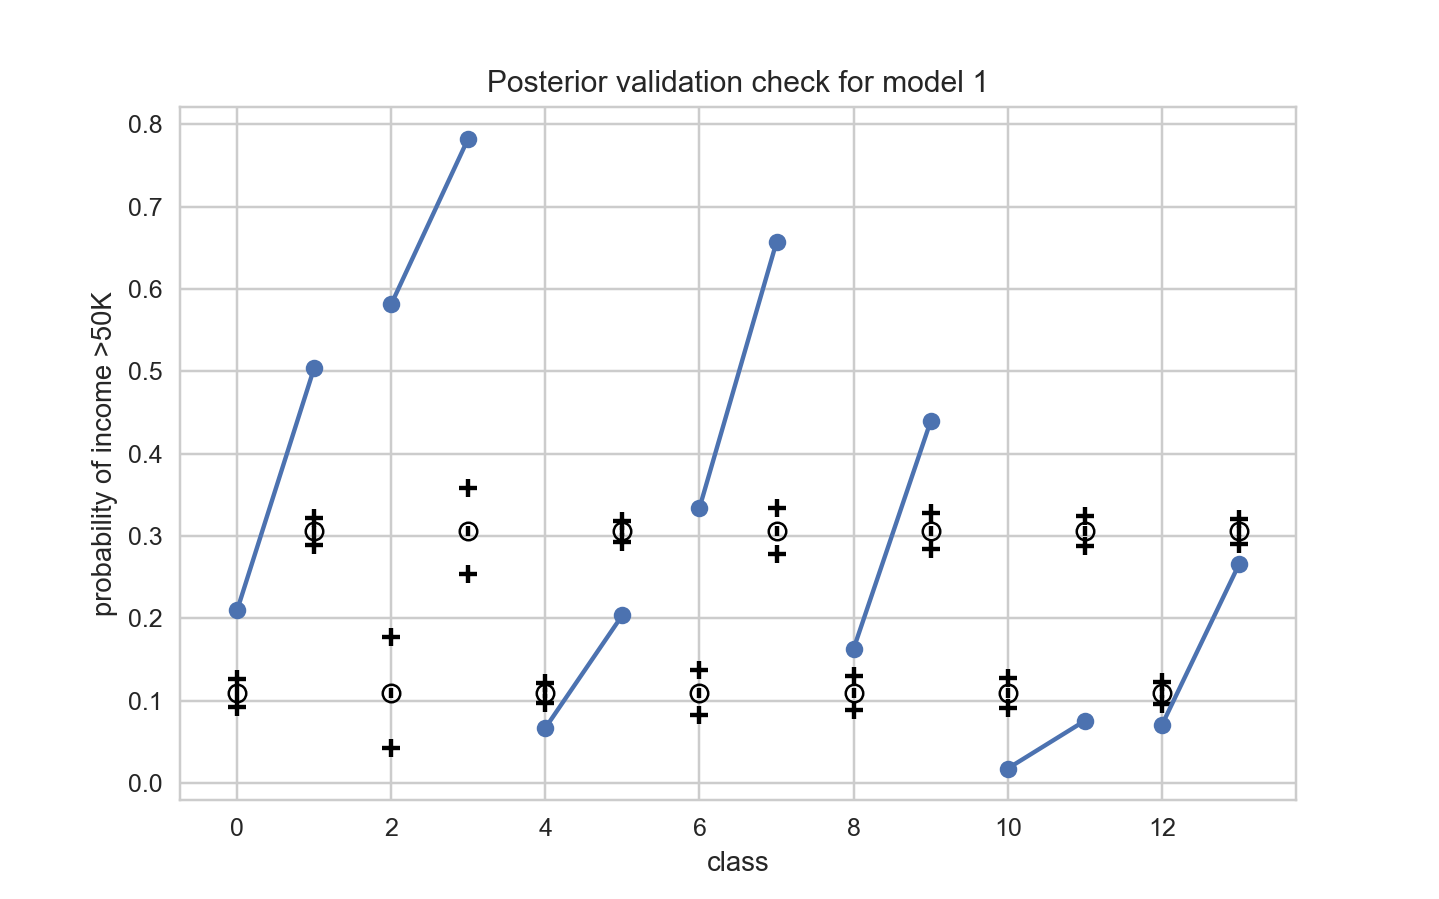

<IPython.core.display.Javascript object>


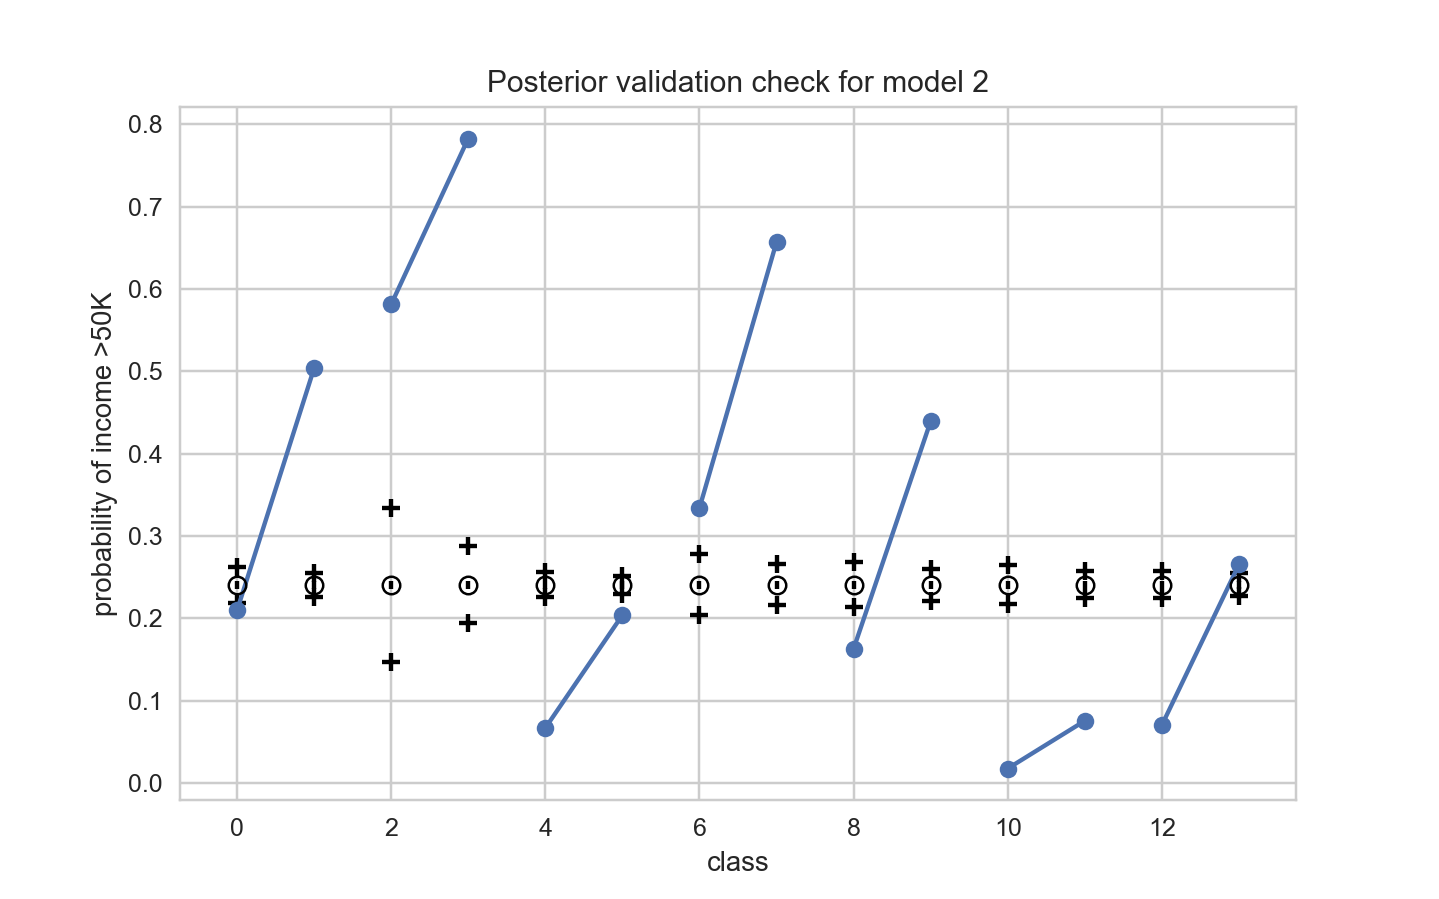

In [17]:
posterior_validation_plot('model 1', model1, trace_model1, spp_model1)
posterior_validation_plot('model 2', model2, trace_model2, spp_model2)

The WAIC scores and the posterior validation check of the two models suggest that model 1 which includes the gender effect fits the data better than model 2 which doesn't include th gender effect. By model 1, the probability of earning above 50K is higher for males (~30%) than for females (~10%). Nevertheless, we see from the posterior validation check plot that model 1 still fits the data poorly. The main problem is that this model did not account for the variations across different education background. 

Taking into account education, we then build the following models by associating the intercept $\alpha$ with the education category such that each category has its own unique intercept. 

Model 3: (include the effect of gender)  

\begin{align}
    n_{\text{>\$50K},i} &\sim \text{Binomial}(n_i, p_i) \\
    \text{logit}(p_i) &= \alpha_{\text{EDUCATION[$i$]}} + \beta_m m_i \\
    \alpha_{\text{EDUCATION[$i$]}} &\sim \text{Normal}(0,10) \\
    \beta_m &\sim \text{Normal}(0,10) \\
\end{align}

Model 4: (does not include the effect of gender)

\begin{align}
    n_{\text{>\$50K},i} &\sim \text{Binomial}(n_i, p_i) \\
    \text{logit}(p_i) &= \alpha_{\text{EDUCATION[$i$]}} \\
    \alpha_{\text{EDUCATION[$i$]}} &\sim \text{Normal}(0,10) \\
\end{align}

In [18]:
def model3():
    with pm.Model() as ps3:
        betam = pm.Normal('betam', 0, 10)
        alpha = pm.Normal('alpha', 0, 10, shape=7)
        logitpi = alpha[df.index//2] + betam*df['is_male']
        above50K = pm.Binomial('above50K', n=df['total'], p=pm.math.invlogit(logitpi), observed=df['>50K'])
    return ps3

def model4():
    with pm.Model() as ps4:
        alpha = pm.Normal('alpha', 0, 10, shape=7)
        logitpi = alpha[df.index//2] 
        above50K = pm.Binomial('above50K', n=df['total'], p=pm.math.invlogit(logitpi), observed=df['>50K'])
    return ps4

In [19]:
model3 = model3()
with model3:
    trace_model3 = pm.sample(10000)
    spp_model3 = pm.sample_ppc(trace_model3)

model4 = model4()
with model4:
    trace_model4 = pm.sample(10000)
    spp_model4 = pm.sample_ppc(trace_model4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, betam]
100%|██████████| 10000/10000 [00:03<00:00, 2652.63it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
100%|██████████| 10000/10000 [00:03<00:00, 2758.43it/s]


In [20]:
names = ['model 1', 'model 2', 'model 3', 'model 4']
dfc = make_compare(names, [trace_model1, trace_model2, trace_model3, trace_model4], [model1, model2, model3, model4])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
model 3,128.31,7.43,0,1,7.75,0,1
model 4,2878.41,710.55,2750.1,0,548.63,543.97,1
model 1,4568.06,490.35,4439.75,0,1156.24,1156.5,1
model 2,6126.16,400.74,5997.86,0,1574.26,1573.17,1


<IPython.core.display.Javascript object>


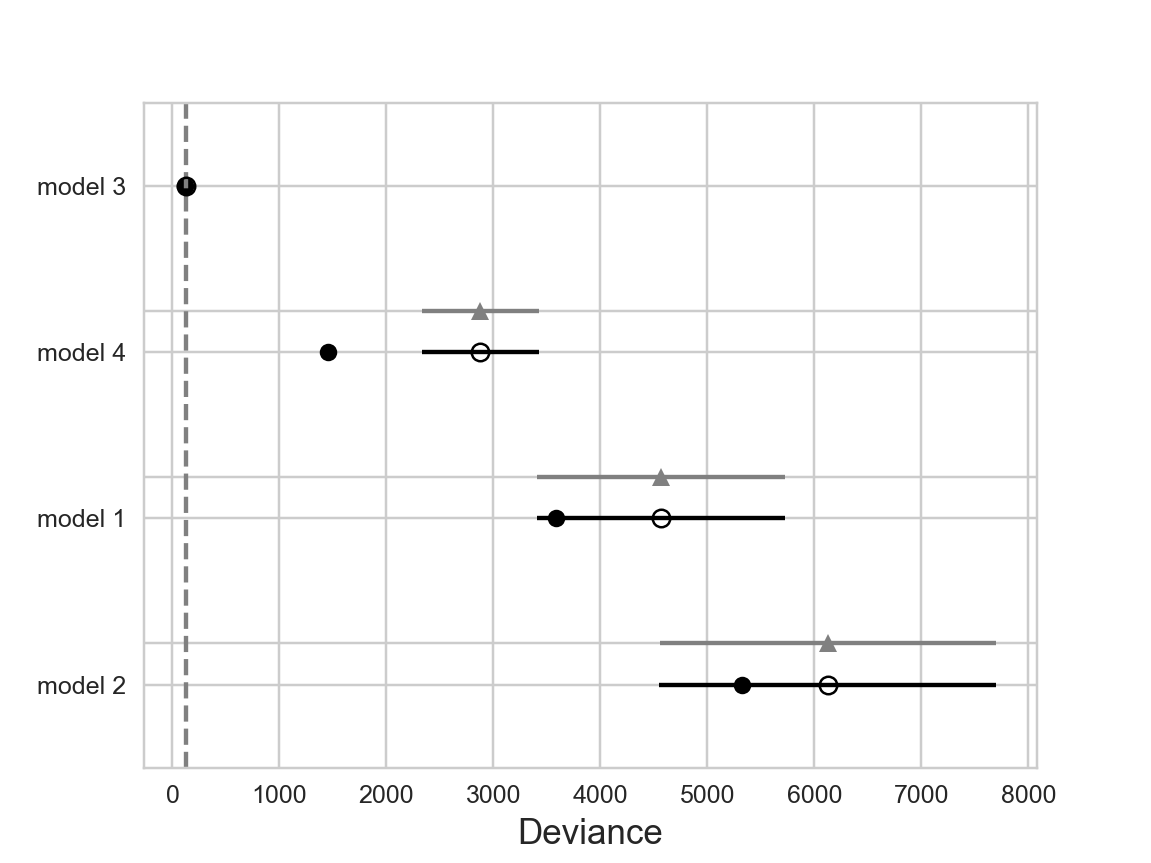

In [22]:
pm.compareplot(dfc)

<IPython.core.display.Javascript object>


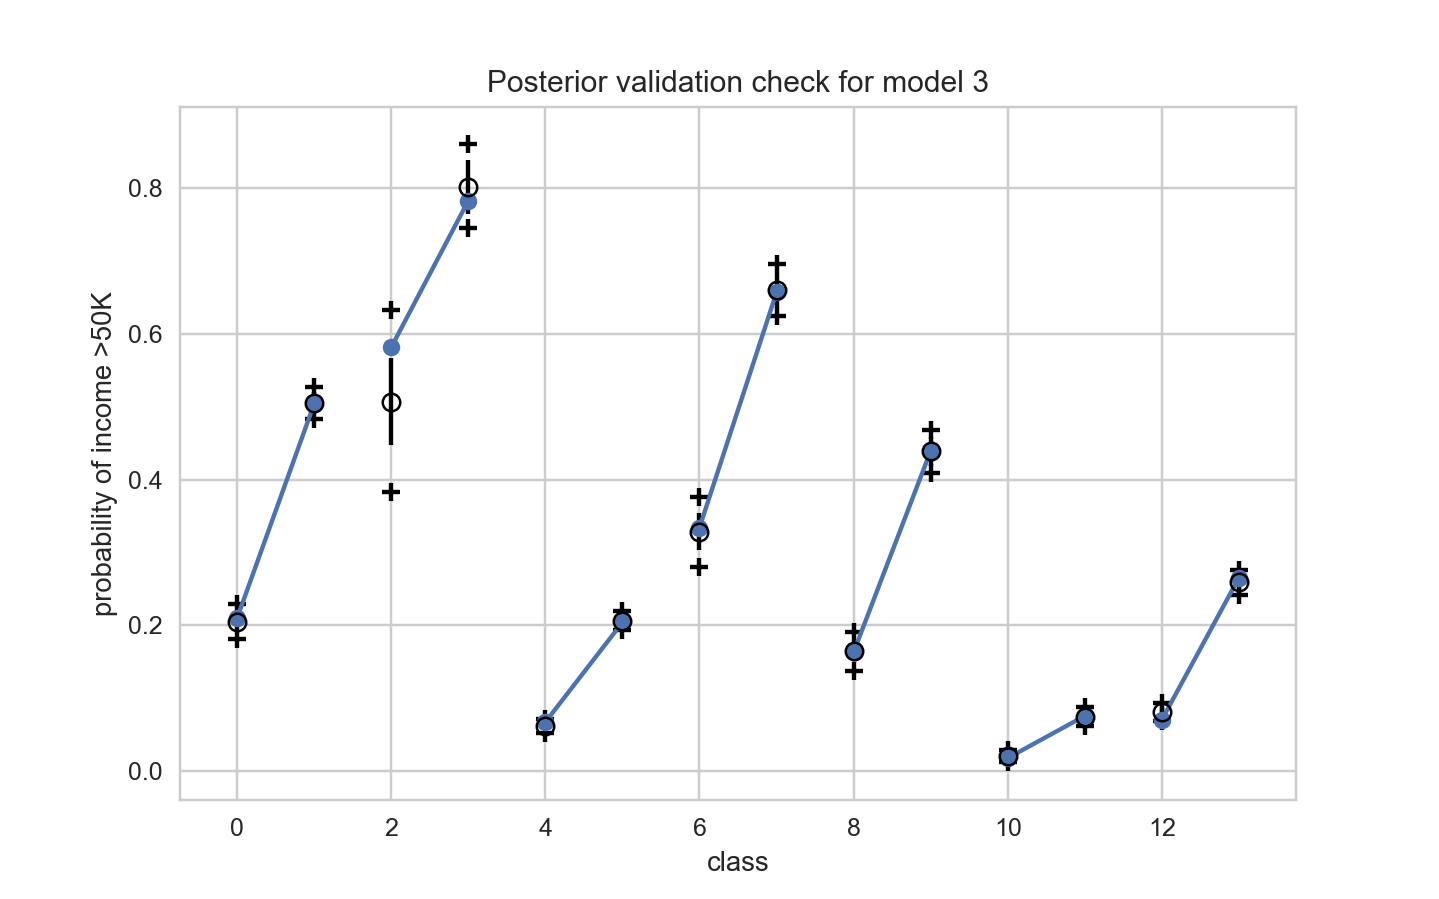

<IPython.core.display.Javascript object>


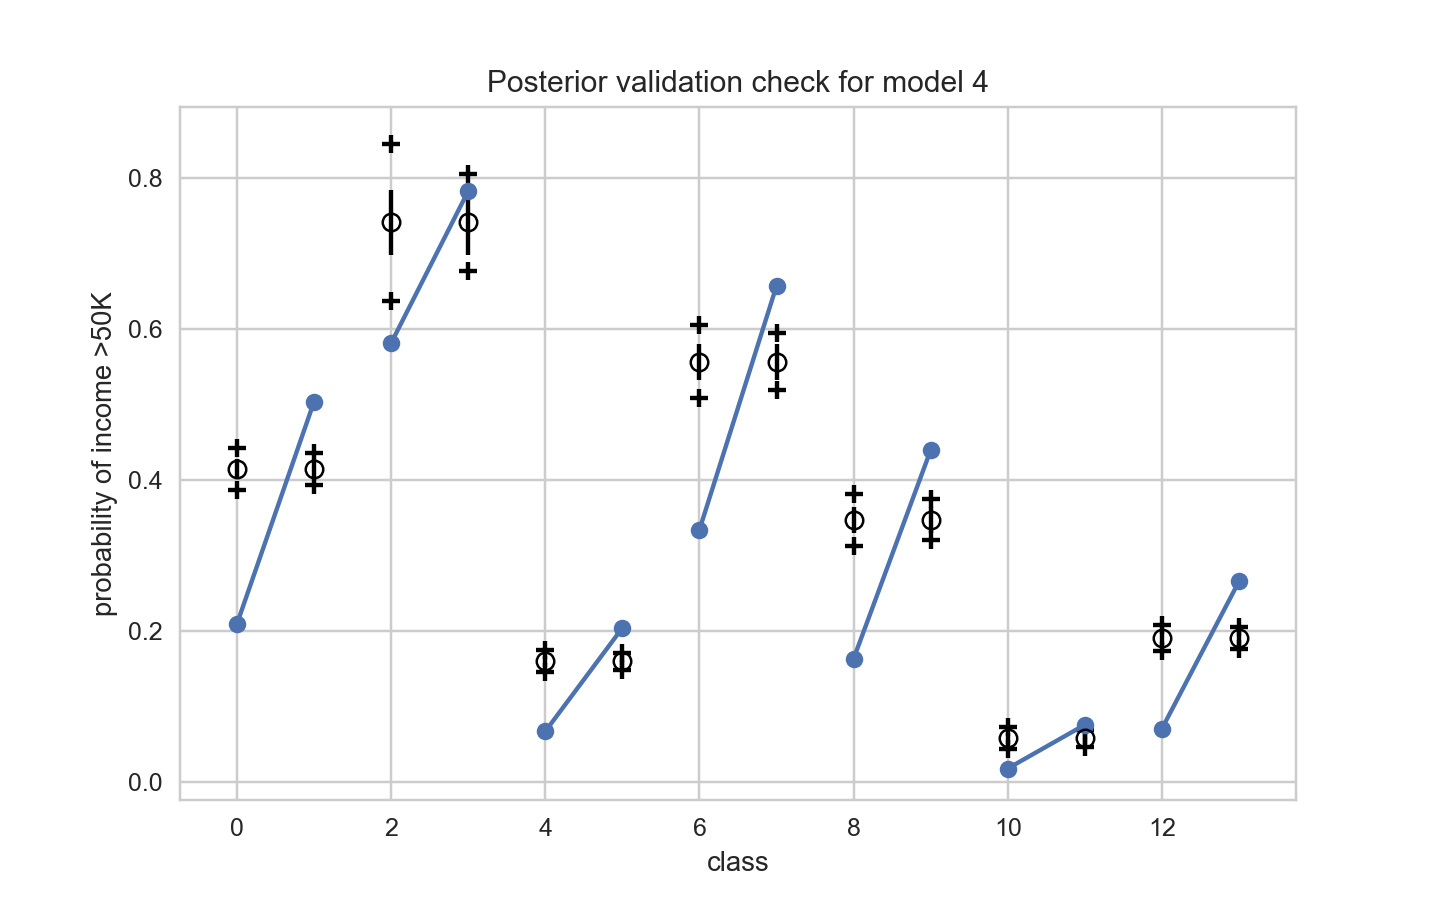

In [21]:
posterior_validation_plot('model 3', model3, trace_model3, spp_model3)
posterior_validation_plot('model 4', model4, trace_model4, spp_model4)

Comparing all four models, we found model 3 (which includes effects of gender and education) fits much better than other three models. Also, model 4 (which includes effects of education but not gender) is ranked higher than the models without education effect, showing that education is truly an important factor. Unlike in the Example 10.1.3, here the WAIC score of model 3 is much lower than the score of model 4. This indicates a strong effect of gender in the case of individual's yearly income. 
***